In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import cem
#from cem.models.cem import ConceptEmbeddingModel
import torchmetrics
from patched_model import PatchedConceptEmbeddingModel
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import os
import matplotlib.pyplot as plt

# Loader #

In [ ]:
# Load prepared data from separate train/val/test files
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "data/processed")

train_path = os.path.join(data_dir, "cem_input.npz")
val_path = os.path.join(data_dir, "cem_input_validation.npz")
test_path = os.path.join(data_dir, "cem_input_test.npz")

# Load training data
train_data = np.load(train_path, allow_pickle=True)
X_train = train_data["X"]
C_train = train_data["C"]
y_train = train_data["y"]
subject_ids_train = train_data["subject_ids"]
concept_names = train_data["concept_names"]

# Load validation data
val_data = np.load(val_path, allow_pickle=True)
X_val = val_data["X"]
C_val = val_data["C"]
y_val = val_data["y"]

# Load test data
test_data = np.load(test_path, allow_pickle=True)
X_test = test_data["X"]
C_test = test_data["C"]
y_test = test_data["y"]

print("Dataset sizes:")
print(f"  Train: {len(y_train)} subjects")
print(f"  Val:   {len(y_val)} subjects")
print(f"  Test:  {len(y_test)} subjects")

print("\nShapes:")
print(f"  X_train: {X_train.shape}, C_train: {C_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}, C_val:   {C_val.shape}, y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}, C_test:  {C_test.shape}, y_test:  {y_test.shape}")

print("\nConcepts:", concept_names)

In [3]:
print(X.shape)

(486, 1152)


In [4]:
# PyTorch Dataset 
class CEMDataset(Dataset):
    def __init__(self, X, C, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.C = torch.tensor(C, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  # <-- float, not long!

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.C[idx]


In [ ]:
# No more programmatic splits - data is already split into train/val/test files!
print(f"Using fixed dataset splits:")
print(f"  Train: {len(y_train)} subjects")
print(f"  Val:   {len(y_val)} subjects")
print(f"  Test:  {len(y_test)} subjects")

print(f"\nLabel distributions:")
print(f"  Train: {np.bincount(y_train)}")
print(f"  Val:   {np.bincount(y_val)}")
print(f"  Test:  {np.bincount(y_test)}")

In [ ]:
# Create datasets using pre-split data (no indexing needed)
train_ds = CEMDataset(X_train, C_train, y_train)
val_ds = CEMDataset(X_val, C_val, y_val)
test_ds = CEMDataset(X_test, C_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Sanity check: inspect one batch and shapes
xb, yb, cb = next(iter(train_loader))
print("Batch shapes from train_loader:")
print("  x batch:", xb.shape)   # (B, input_dim)
print("  y batch:", yb.shape)   # (B,)
print("  c batch:", cb.shape)   # (B, n_concepts)

In [ ]:
# Parameters 
input_dim = X_train.shape[1]    # SBERT embedding size (384 * 3 = 1152)
n_concepts = C_train.shape[1]   # number of concepts from questionnaire (21)
n_tasks = 1                     # binary classification (depressed vs control)
emb_size = 128                  # size of concept embedding inside CEM

# Define concept extractor architecture
def c_extractor_arch(output_dim: int):
    layers = [
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
    ]
    if output_dim is not None:
        layers.append(nn.Linear(256, output_dim))
    else:
        # keep dimensionality stable for CEM to inspect
        layers.append(nn.Linear(256, 256))
    return nn.Sequential(*layers)


# Instantiate Concept Embedding Model
cem_model = PatchedConceptEmbeddingModel(
    n_concepts=n_concepts,
    n_tasks=n_tasks,
    input_dim=input_dim,
    emb_size=emb_size,
    concept_loss_weight=1.0,
    training_intervention_prob=0.25,
    c_extractor_arch=c_extractor_arch,
    c2y_model=None  
)

print(cem_model)

In [8]:

# Reproducibility
pl.seed_everything(42)

# Logger (saves metrics to logs/)
logger = CSVLogger(save_dir="../logs", name="cem_experiment")

# Trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
    logger=logger,
    log_every_n_steps=10,
    check_val_every_n_epoch=1
)

# Train the CEM model
trainer.fit(cem_model, train_loader, val_loader)


Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name                       | Type              | Params
-----------------------------------------------------------------
0 | pre_concept_model          | Sequential        | 360 K 
1 | concept_context_generators | ModuleList        | 1.4 M 
2 | concept_prob_generators    | ModuleList        | 257   
3 | c2y_model                  | Sequential       

Sanity Checking: 0it [00:00, ?it/s]

/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [9]:
# ---------- Evaluation block (replace your WIP block) ----------
import numpy as np
import torch
from scipy.special import expit  # sigmoid
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    balanced_accuracy_score,
    classification_report,
)

# Put model in eval mode
cem_model.eval()

y_true_list = []
y_pred_list = []
y_prob_list = []

# Determine device to put inputs on, prefer model.device if present
device = getattr(cem_model, "device", None)
if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for xb, yb, cb in test_loader:
        xb = xb.to(device)
        # forward might return (c_pred, c_embs, y_logits) or similar,
        # adapt if your CEM returns a dict or tuple with different order.
        out = cem_model(xb)

        # Try to extract y_logits conservatively, handle common return shapes.
        if isinstance(out, tuple) or isinstance(out, list):
            # assume last element is the task logits
            y_logits = out[-1]
        elif isinstance(out, dict):
            # common dict keys might be 'y_logits' or 'task_logits' or 'y_pred'
            for k in ("y_logits", "task_logits", "y_pred", "y"):
                if k in out:
                    y_logits = out[k]
                    break
            else:
                raise RuntimeError("Could not find logits in model output dict, keys: " + ", ".join(out.keys()))
        else:
            raise RuntimeError("Unrecognized model output type: " + str(type(out)))

        # move logits to cpu numpy for metric computation
        y_logits = y_logits.detach().cpu().squeeze()

        # If logits shape is (B,1) or (B,), make sure we have (B,)
        if y_logits.ndim == 2 and y_logits.shape[1] == 1:
            y_logits = y_logits[:, 0]

        # Convert ground truth to numpy ints
        yb_numpy = yb.numpy().astype(int).ravel()

        # Convert logits to probabilities using sigmoid for binary
        y_probs = expit(y_logits.numpy()) if isinstance(y_logits, torch.Tensor) else expit(y_logits)
        # If shape (B, n_tasks) and n_tasks>1, handle accordingly; here we assume single task
        if y_probs.ndim > 1:
            # If multi-task with 1 column, squeeze it
            if y_probs.shape[1] == 1:
                y_probs = y_probs[:, 0]
            else:
                raise RuntimeError("Detected multi-column y_probs, this evaluation code assumes a single binary task")

        y_pred = (y_probs >= 0.5).astype(int)

        y_true_list.extend(yb_numpy.tolist())
        y_pred_list.extend(y_pred.tolist())
        y_prob_list.extend(y_probs.tolist())

# Convert to numpy arrays
y_true = np.array(y_true_list, dtype=int)
y_pred = np.array(y_pred_list, dtype=int)
y_prob = np.array(y_prob_list, dtype=float)

# Basic checks
assert y_true.shape == y_pred.shape, "y_true and y_pred shape mismatch"
n_samples = len(y_true)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# For binary classification scikit returns array([[TN, FP], [FN, TP]])
tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (None, None, None, None)

# Metrics
acc = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

precision_micro = precision_score(y_true, y_pred, average="micro", zero_division=0)
recall_micro = recall_score(y_true, y_pred, average="micro", zero_division=0)
f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)

precision_binary = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
recall_binary = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
f1_binary = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

mcc = matthews_corrcoef(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)

# ROC AUC for binary, requires at least two classes present in y_true
try:
    roc_auc = roc_auc_score(y_true, y_prob)
except ValueError:
    roc_auc = float("nan")  # not defined if only one class present in y_true

# Print results
print("\nEvaluation summary")
print("==================")
print(f"Samples evaluated: {n_samples}")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Matthews correlation coefficient: {mcc:.4f}")
print("")
print("F1 scores:")
print(f"  binary (positive label=1): {f1_binary:.4f}")
print(f"  macro average: {f1_macro:.4f}")
print(f"  micro average: {f1_micro:.4f}")
print("")
print("Confusion matrix (rows=true, cols=pred):")
print(cm)
if tn is not None:
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print("")
print("Classification report (precision, recall, f1, support):")
print(classification_report(y_true, y_pred, zero_division=0))

# Optionally, save metrics to the trainer logger CSV or a json file
metrics_dict = {
    "n_samples": n_samples,
    "accuracy": float(acc),
    "balanced_accuracy": float(balanced_acc),
    "roc_auc": float(roc_auc) if not np.isnan(roc_auc) else None,
    "mcc": float(mcc),
    "f1_binary": float(f1_binary),
    "f1_macro": float(f1_macro),
    "f1_micro": float(f1_micro),
}
# Example saving to a file
import json
with open("../logs/eval_metrics.json", "w") as fh:
    json.dump(metrics_dict, fh, indent=2)
print("Saved metrics to ../logs/eval_metrics.json")



Evaluation summary
Samples evaluated: 98
Accuracy: 0.9286
Balanced accuracy: 0.8638
ROC AUC: 0.9637
Matthews correlation coefficient: 0.7455

F1 scores:
  binary (positive label=1): 0.7879
  macro average: 0.8725
  micro average: 0.9286

Confusion matrix (rows=true, cols=pred):
[[78  3]
 [ 4 13]]
TN: 78, FP: 3, FN: 4, TP: 13

Classification report (precision, recall, f1, support):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        81
           1       0.81      0.76      0.79        17

    accuracy                           0.93        98
   macro avg       0.88      0.86      0.87        98
weighted avg       0.93      0.93      0.93        98

Saved metrics to ../logs/eval_metrics.json


In [10]:
# Ensure model in eval mode
cem_model.eval()

# Accumulators
y_true_list = []
y_pred_list = []
y_prob_list = []
all_concept_probs = []

# Choose device
device = getattr(cem_model, "device", None)
if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# try to move model to device if needed
try:
    cem_model.to(device)
except Exception:
    pass

with torch.no_grad():
    for xb, yb, cb in test_loader:
        xb = xb.to(device)

        out = cem_model(xb)
        # handle tuple/list outputs (common API)
        if isinstance(out, (tuple, list)):
            c_pred = out[0]
            y_logits = out[-1]
        elif isinstance(out, dict):
            # conservative lookups for concept preds and logits
            c_pred = out.get("c_pred") or out.get("c_probs") or out.get("concepts") or None
            for k in ("y_logits", "task_logits", "y_pred", "y"):
                if k in out:
                    y_logits = out[k]
                    break
            else:
                raise RuntimeError("Could not find y logits in model output dict, keys: " + ", ".join(out.keys()))
            if c_pred is None:
                # fallback: pick a key that looks like concept output
                for k in out.keys():
                    if "concept" in k.lower() or "c_" in k.lower():
                        c_pred = out[k]
                        break
                if c_pred is None:
                    raise RuntimeError("Could not find concept preds in model output dict")
        else:
            raise RuntimeError(f"Unrecognized model output type: {type(out)}")

        # move to cpu for numpy conversions
        c_pred_cpu = c_pred.detach().cpu() if isinstance(c_pred, torch.Tensor) else torch.tensor(np.asarray(c_pred))
        # heuristic: if values outside [0,1], treat as logits and apply sigmoid
        if float(torch.min(c_pred_cpu)) < -1e-6 or float(torch.max(c_pred_cpu)) > 1.0 + 1e-6:
            c_probs = torch.sigmoid(c_pred_cpu).numpy()
        else:
            c_probs = c_pred_cpu.numpy()

        # handle y_logits -> probabilities
        y_logits_cpu = y_logits.detach().cpu() if isinstance(y_logits, torch.Tensor) else np.asarray(y_logits)
        if isinstance(y_logits_cpu, torch.Tensor):
            y_logits_cpu = y_logits_cpu.squeeze()
            if y_logits_cpu.ndim == 2 and y_logits_cpu.shape[1] == 1:
                y_logits_cpu = y_logits_cpu[:, 0]
            y_probs_batch = expit(y_logits_cpu.numpy())
        else:
            arr = np.asarray(y_logits_cpu)
            if arr.ndim == 2 and arr.shape[1] == 1:
                arr = arr[:, 0]
            y_probs_batch = expit(arr)

        # ground truth batch
        yb_numpy = yb.numpy().astype(int).ravel()
        y_pred_batch = (y_probs_batch >= 0.5).astype(int)

        # extend accumulators per batch
        y_true_list.extend(yb_numpy.tolist())
        y_pred_list.extend(y_pred_batch.tolist())
        y_prob_list.extend(y_probs_batch.tolist())

        # ensure c_probs shape is (B, n_concepts)
        c_probs = np.asarray(c_probs)
        if c_probs.ndim == 1:
            c_probs = c_probs[np.newaxis, :]
        all_concept_probs.extend(c_probs.tolist())

# final arrays
y_true = np.array(y_true_list, dtype=int)
y_pred = np.array(y_pred_list, dtype=int)
y_prob = np.array(y_prob_list, dtype=float)
all_concept_probs = np.array(all_concept_probs, dtype=float)

# quick sanity check
print("Sanity shapes: y_true", y_true.shape, "y_pred", y_pred.shape, "y_prob", y_prob.shape, "concepts", all_concept_probs.shape)

# make sure shapes match before proceeding
assert y_true.shape == y_pred.shape == y_prob.shape == (all_concept_probs.shape[0],), "shape mismatch after aggregation"

# metrics
n_samples = len(y_true)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (None, None, None, None)

acc = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

precision_binary = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
recall_binary = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
f1_binary = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

mcc = matthews_corrcoef(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
try:
    roc_auc = roc_auc_score(y_true, y_prob)
except Exception:
    roc_auc = float("nan")

print("\nEvaluation summary")
print("==================")
print(f"Samples evaluated: {n_samples}")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Matthews correlation coefficient: {mcc:.4f}")
print("")
print("F1 scores:")
print(f"  binary (positive label=1): {f1_binary:.4f}")
print(f"  macro average: {f1_macro:.4f}")
print("")
print("Confusion matrix (rows=true, cols=pred):")
print(cm)
if tn is not None:
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print("")
print("Classification report:")
print(classification_report(y_true, y_pred, zero_division=0))

# save metrics and per-sample concept probs
os.makedirs("../logs", exist_ok=True)
with open("../logs/eval_metrics.json", "w") as fh:
    json.dump({"n_samples": n_samples, "accuracy": float(acc), "balanced_accuracy": float(balanced_acc),
               "roc_auc": (float(roc_auc) if not np.isnan(roc_auc) else None), "mcc": float(mcc),
               "f1_binary": float(f1_binary)}, fh, indent=2)
print("Saved metrics to ../logs/eval_metrics.json")

# write per-sample CSV
concept_names_list = list(concept_names) if 'concept_names' in globals() else [f"c{i}" for i in range(all_concept_probs.shape[1])]
header = ["subject_idx", "y_true", "y_pred", "y_prob"] + concept_names_list
csv_path = "../logs/test_concept_probs.csv"
with open(csv_path, "w") as fh:
    fh.write(",".join(header) + "\n")
    for i in range(n_samples):
        row = [str(i), str(y_true[i]), str(y_pred[i]), f"{y_prob[i]:.6f}"] + [f"{v:.6f}" for v in all_concept_probs[i]]
        fh.write(",".join(row) + "\n")
print("Saved per-sample concept probs to", csv_path)

Sanity shapes: y_true (98,) y_pred (98,) y_prob (98,) concepts (98, 21)

Evaluation summary
Samples evaluated: 98
Accuracy: 0.9286
Balanced accuracy: 0.8638
ROC AUC: 0.9637
Matthews correlation coefficient: 0.7455

F1 scores:
  binary (positive label=1): 0.7879
  macro average: 0.8725

Confusion matrix (rows=true, cols=pred):
[[78  3]
 [ 4 13]]
TN: 78, FP: 3, FN: 4, TP: 13

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        81
           1       0.81      0.76      0.79        17

    accuracy                           0.93        98
   macro avg       0.88      0.86      0.87        98
weighted avg       0.93      0.93      0.93        98

Saved metrics to ../logs/eval_metrics.json
Saved per-sample concept probs to ../logs/test_concept_probs.csv


In [11]:


# all_concept_probs is (n_samples, n_concepts)
print("shape:", all_concept_probs.shape)

# global min/max
print("global min:", all_concept_probs.min(), "global max:", all_concept_probs.max())

# per-concept min/max
per_min = all_concept_probs.min(axis=0)
per_max = all_concept_probs.max(axis=0)
for i,(mn,mx) in enumerate(zip(per_min, per_max)):
    print(f"concept {i}: min {mn:.4f}, max {mx:.4f}")

# show first 5 samples as a DataFrame, optionally include subject ids if you saved them
df = pd.DataFrame(all_concept_probs, columns=concept_names if 'concept_names' in globals() else [f"c{i}" for i in range(all_concept_probs.shape[1])])
df["y_true"] = y_true
df["y_pred"] = y_pred
print(df.head(5).T)   # transpose so it's easy to read per-sample per-concept


shape: (98, 21)
global min: 3.327229933347553e-06 global max: 0.48010534048080444
concept 0: min 0.0000, max 0.1655
concept 1: min 0.0005, max 0.3664
concept 2: min 0.0002, max 0.4240
concept 3: min 0.0000, max 0.1542
concept 4: min 0.0000, max 0.0924
concept 5: min 0.0001, max 0.1252
concept 6: min 0.0122, max 0.4801
concept 7: min 0.0000, max 0.1767
concept 8: min 0.0000, max 0.0699
concept 9: min 0.0000, max 0.0710
concept 10: min 0.0000, max 0.0200
concept 11: min 0.0001, max 0.2267
concept 12: min 0.0001, max 0.1962
concept 13: min 0.0003, max 0.2963
concept 14: min 0.0002, max 0.3009
concept 15: min 0.0000, max 0.1575
concept 16: min 0.0000, max 0.0385
concept 17: min 0.0002, max 0.1014
concept 18: min 0.0003, max 0.1966
concept 19: min 0.0000, max 0.1618
concept 20: min 0.0000, max 0.0732
                                    0         1         2         3         4
Sadness                      0.085270  0.005571  0.000668  0.001676  0.000124
Pessimism                    0.246008

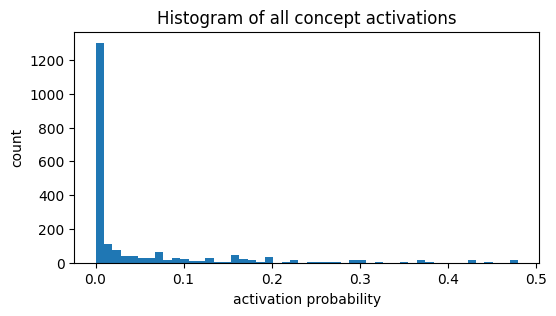

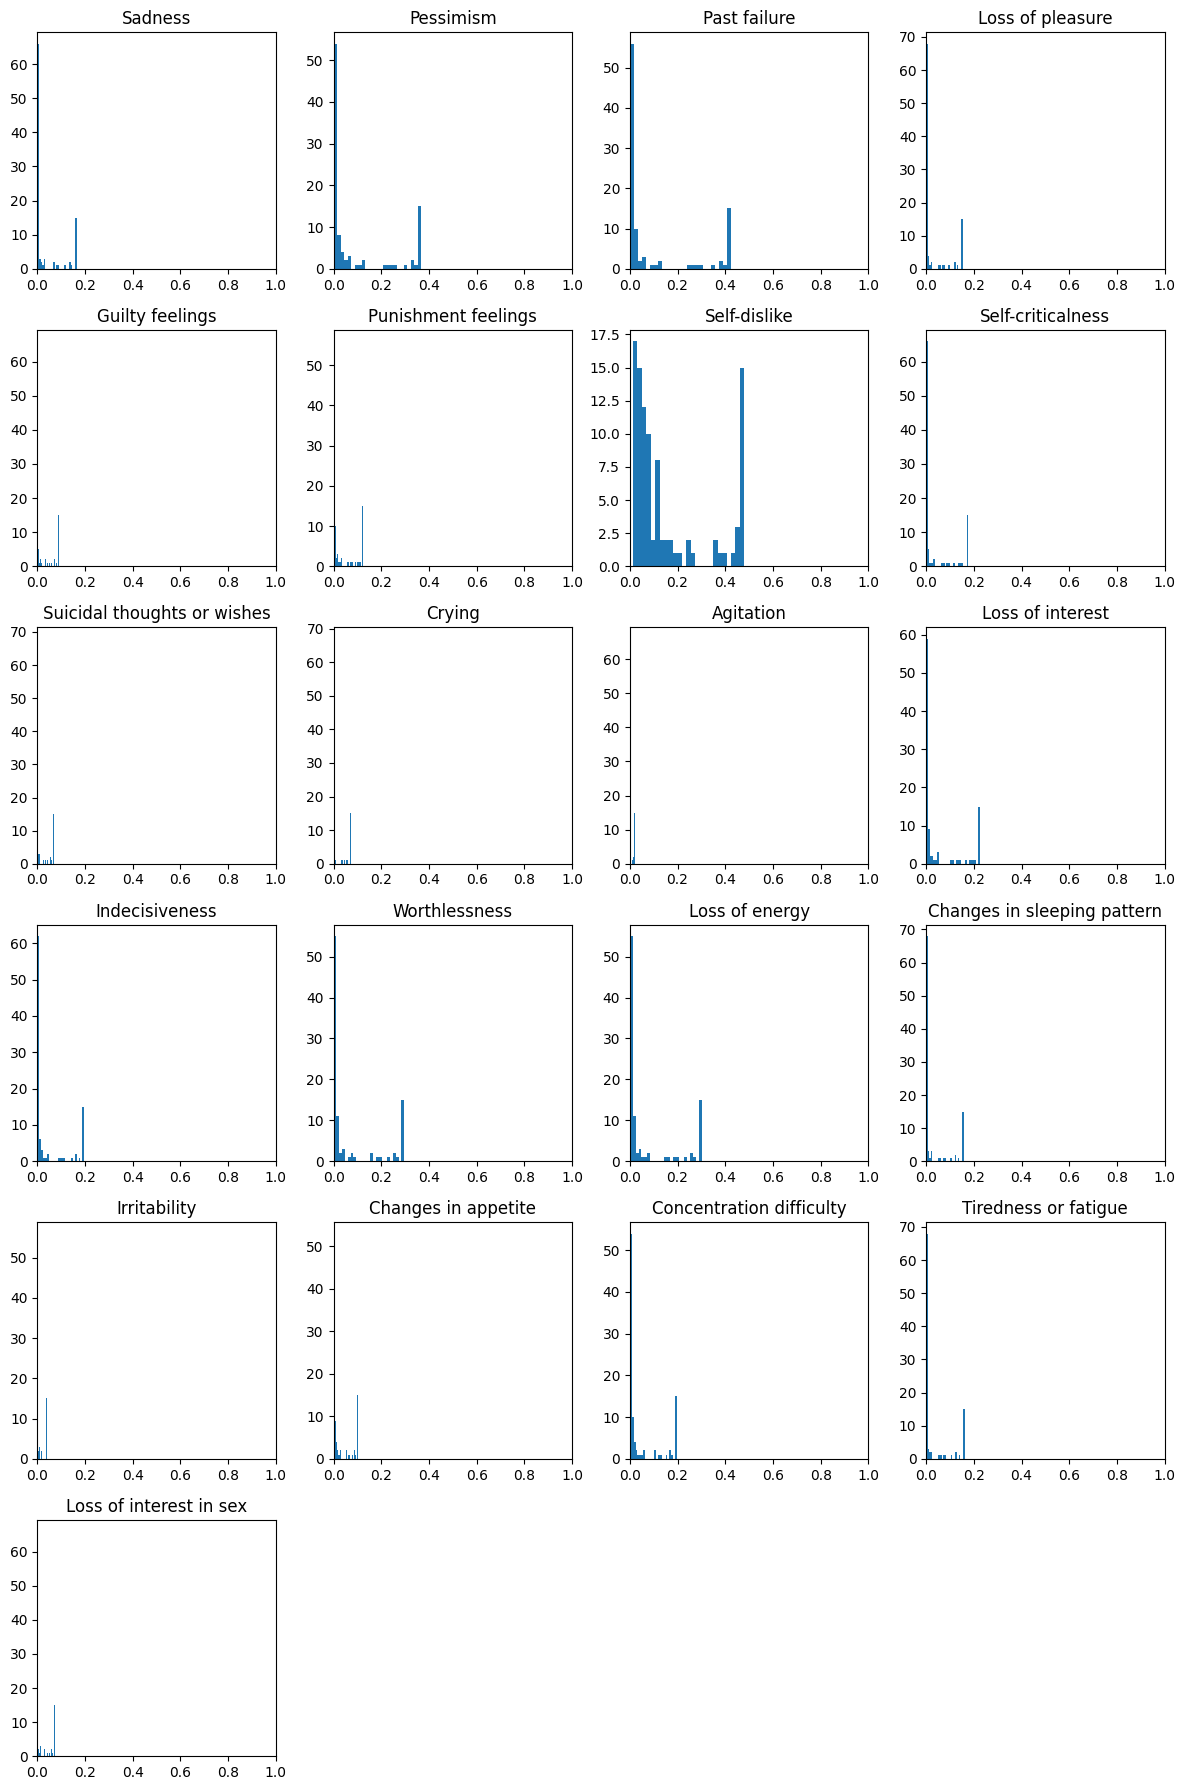

In [12]:


# overall histogram
plt.figure(figsize=(6,3))
plt.hist(all_concept_probs.ravel(), bins=50)
plt.title("Histogram of all concept activations")
plt.xlabel("activation probability")
plt.ylabel("count")
plt.show()

# per-concept histograms (compact)
n = all_concept_probs.shape[1]
rows = int(np.ceil(n/4))
plt.figure(figsize=(12, 3*rows))
for i in range(n):
    plt.subplot(rows, 4, i+1)
    plt.hist(all_concept_probs[:, i], bins=25)
    plt.title(concept_names[i] if 'concept_names' in globals() else f"c{i}")
    plt.xlim(0,1)
plt.tight_layout()
plt.show()
